In [98]:
import numpy as np
import pandas as pd

import astropy.units as u
#gravitational constant, Jupiter mass, Solar mass, speed of light:
from astropy.constants import G, M_jup, M_sun, M_earth, c 

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

### Calculate the maximum relative velocity  $RV$ of the Sun 

Assume: 
 - circular orbit, or $e=0$
 - we can neglect all other bodies in the solar system
 - we observe the system edge-on so that we can actually measure the maximum possible $RV$

#### Kepler's 3rd law

$T^2 = \dfrac{4 \pi^2 a^3}{G M_{tot}}$

#### Sun's distance to the barycenter of the Sun-Jupiter system

Center of mass definition:

$M_p a = M_s r$

$a_p$, $r$ are the semi-major axes of planet and star, respectively.

$r = \dfrac{M_p \cdot a }{M_{tot}}$

#### Radial velocity

$RV = \dfrac{2 \pi r}{T} \sim M_p \cdot a^{-1/2} \cdot M_{tot}^{-1/2}$ 


##### Note that we measure $RV = v_{\mathrm{true\; radial\; velocity}} \sin i$ with inclination $i$.

#### Time dependence

$VR(t)$ = v_0 + v_{\mathrm{true\; radial\; velocity}} \sin i (\frac{2\pi}{T}\cdot t + \phi)

$v_0$ radial motion of the system

$\phi$ planetary orbital phase 

## What minimum spectrograph resolution do we need for this?

$R = \dfrac{\lambda}{\Delta \lambda} = \dfrac{c}{RV}$

Will arbitrary spectral resolution solve all our problems?

No, because rotational, activity, turbulent broadening. Better than 60000 hit marginal returns (see [Beatty and Gaudi 2015](https://iopscience.iop.org/article/10.1086/684264/pdf)).

Instruments:

- [HARPS](http://www.eso.org/sci/facilities/lasilla/instruments/harps/overview.html)
- HiRES

Also, we don't need that high $R$. We use cross-correlation of the spectra with model lines. Peak in the cross-correlation function give a peak a required $\Delta \lambda$.

In [97]:
def calculate_RV(a, Mp, Ms):
    """Radial Velocity.
    
    Parameters:
    -----------
    a : float or array
        star-planet distance in AU
    Mp : float or array
        planet mass in Jupiter masses
    Ms : float or array
        stellar mass in Solar masses
    
    Return:
    -------
    float or array : radial velocity
    """
    # distance star-planet
    a = a * u.AU

    # Kepler's 3rd law
    Mp = Mp * M_jup
    Ms = Ms * M_sun
    T = np.sqrt(4 * np.pi**2 * a**3 / (G * (Mp + Ms)))

    #Sun's distance to the barycenter of the Sun-Jupiter system
    r = Mp * a / (Ms + Mp)

    #Sun's orbital velocity around the barycenter of the Sun-Jupiter system
    rv = 2 * np.pi * r / T
    return rv.to("m/s")

In [3]:
def calculate_spectral_resolution(rv):
    """Spectral resolution from radial
    velocity.
    
    Parameter:
    ----------
    rv : astropy velocity
        radial velocity
    
    Returns:
    ---------
    float or array : spectral resolution    
    """
    R = c / rv
    return R.decompose()

### Results

In [83]:
a_ = np.logspace(-3,2,30)
Mp_ = np.logspace(-4, 2, 30)
Ms_ = np.linspace(.1, 1.5, 29)
Ms_

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ])

In [94]:
index = pd.MultiIndex.from_product([a_, Mp_, Ms_],
                            names=['a', 'Mp', 'Ms'])
df = pd.DataFrame(index=index)
df = df.reset_index()
df["RV"] = df.apply(lambda x: calculate_RV(x.a, x.Mp, x.Ms), axis=1)
df["R"] = df.apply(lambda x: calculate_spectral_resolution(x.RV), axis=1)
df.RV = df.RV.apply(lambda x: x.value)
df.R = df.R.apply(lambda x: x.value)

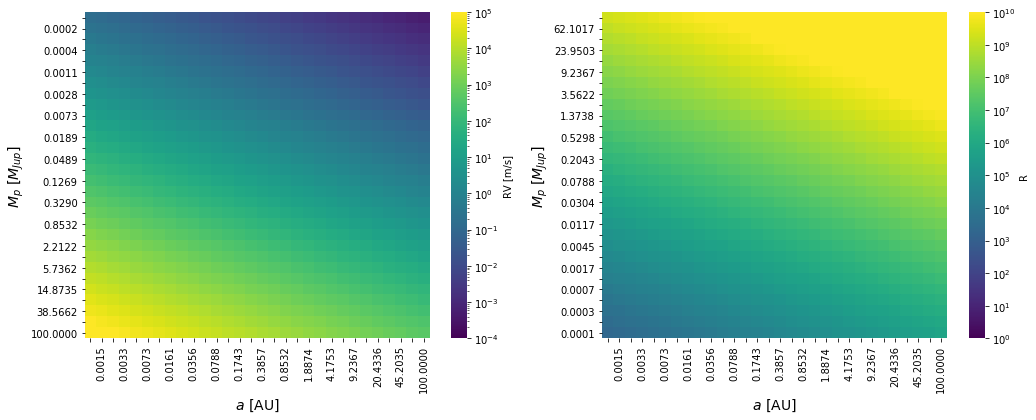

In [95]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,6))
df2 = df[np.isclose(df.Ms, .3)].pivot(columns='a',index='Mp',values='RV')
from matplotlib.colors import LogNorm
seaborn.heatmap(df2, cmap="viridis",cbar_kws={'label': "RV [m/s]", "ticks":np.logspace(-4,5,10)},
                              vmin=1e-4, vmax=1e5, annot=False, ax=ax[0],
                              yticklabels=["{:.4f}".format(x) for x in df2.index.values],
                              xticklabels=["{:.4f}".format(x) for x in df2.columns.values],
                              norm=LogNorm(vmin=1e-4, vmax=1e5));

df2 = df[np.isclose(df.Ms, .3)].pivot(columns='a',index='Mp',values='R')
from matplotlib.colors import LogNorm
seaborn.heatmap(df2, cmap="viridis",cbar_kws={'label': "R", "ticks":np.logspace(0,10,11)},
                              vmin=1, vmax=1e10, annot=False, ax=ax[1],
                              yticklabels=["{:.4f}".format(x) for x in df2.index.values[::-1]],
                              xticklabels=["{:.4f}".format(x) for x in df2.columns.values],
                              norm=LogNorm(vmin=1, vmax=1e10));



for axis in ax:
    for label in axis.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    for label in axis.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)  
    axis.set_xlabel(r"$a$ [AU]", fontsize=14)
    axis.set_ylabel(r"$M_p$ [$M_{Jup}$]", fontsize=14)